<a href="https://colab.research.google.com/github/cormac-black/chekhovs-biscuit/blob/main/back_at_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import random
import cv2



 def: posterize_it; input: img_raw, dtype=uint8,shape=(500, 333, 3)


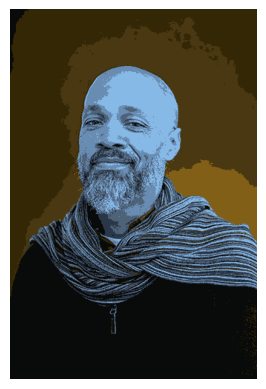


 def:post2grey; input: post_img, dtype=uint8,shape=(500, 333)


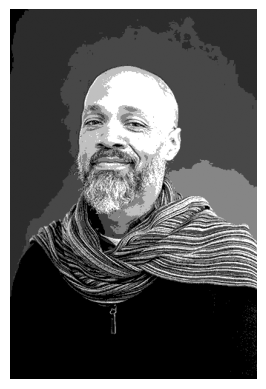


 def: {filter_used}, dtype=uint8,shape=(500, 333, 3)


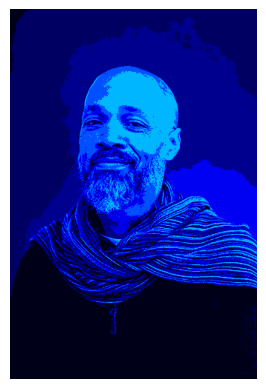

cv2.COLORMAP_HOT

 final, dtype=uint8,shape=(500, 333, 3)


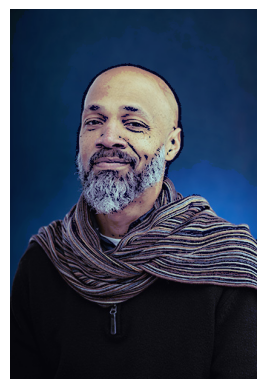

In [97]:
from re import I
from PIL.Image import composite


img_path = '/content/headshot.jpg' # cv2 starts with image path
# img_path = '/content/muerta.PNG'
# img_path = '/content/freckle_flower.jpg'
img_raw = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

def display_img(img, title=None):

  plt.imshow(img)
  plt.axis('off')
  print(f'\n {title}, dtype={img.dtype},shape={img.shape}')
  plt.show()

def display_img_gray(img, title=None):

  plt.imshow(img, cmap='gray')
  plt.axis('off')
  print(f'\n {title}, dtype={img.dtype},shape={img.shape}')
  plt.show()

def post2gray(img):
  img_grayPoster = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img_grayPoster

def rando_filter(img):

  colormap_dict = {
	0: "cv2.COLORMAP_AUTUMN",
	1: "cv2.COLORMAP_BONE", ##
	2: "cv2.COLORMAP_JET",
	3: "cv2.COLORMAP_WINTER", #*
	4: "cv2.COLORMAP_RAINBOW",
	5: "cv2.COLORMAP_OCEAN",
	6: "cv2.COLORMAP_SUMMER",
	7: "cv2.COLORMAP_SPRING",
	8: "cv2.COLORMAP_COOL",
	9: "cv2.COLORMAP_HSV",
	10: "cv2.COLORMAP_PINK", ##
	11: "cv2.COLORMAP_HOT",
	12: "cv2.COLORMAP_PARULA",
	13: "cv2.COLORMAP_MAGMA",
	14: "cv2.COLORMAP_INFERNO",
	15: "cv2.COLORMAP_PLASMA",
	16: "cv2.COLORMAP_VIRIDIS",
	17: "cv2.COLORMAP_CIVIDIS",
	18: "cv2.COLORMAP_TWILIGHT",
	19: "cv2.COLORMAP_TWILIGHT_SHIFTED",
	20: "cv2.COLORMAP_TURBO",
	21: "cv2.COLORMAP_DEEPGREEN"
	}

  rando = random.randint(0,21)
  keys_list = list(colormap_dict.keys())
  filter_numb = keys_list[rando]
  filter_used = colormap_dict[filter_numb]
  color_mapped_img = cv2.applyColorMap(img, rando)

  return color_mapped_img, filter_used

def overlay_it(img):
    # Read background
    bg = img
    bg = cv2.cvtColor (bg, cv2.COLOR_BGR2RGB)
    if bg is None:
        print(f"Image not found at: {img_path}")
        return None

    # Convert background image to grayscale for edge detection
    gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)

    # Edge detection
    # 2nd to last # must be odd
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 19, 32)

    # White mask (white = 255, transparent areas)
    white_mask = (edges == 255)
    alpha = (~white_mask).astype(np.uint8) * 255  # alpha=255 where edge is black

    # Convert edges to an RGB image
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Stack to make RGBA
    rgba = np.dstack([edges_rgb, alpha])

    # Resize overlay to match background, SHIT...
    if rgba.shape[:2] != bg.shape[:2]:
        rgba = cv2.resize(rgba, (bg.shape[1], bg.shape[0]))

    # Prepare for blending
    foreground = rgba.astype(float) / 255.0
    background = bg.astype(float) / 255.0
    alpha_channel = foreground[..., 3][..., None]

    # Blend!
    composite = alpha_channel * foreground[..., :3] + (1.0 - alpha_channel) * background
    composite = (composite * 255).astype(np.uint8)

    return composite, edges

def posterize_it(img):

  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  pixel_values = img.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  k = 8
  _, labels, centers = cv2.kmeans(pixel_values, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .2), 10, cv2.KMEANS_RANDOM_CENTERS)
  centers = np.uint8(centers)

  posterized_img_local = centers[labels.flatten()]
  posterized_img_local = posterized_img_local.reshape(img.shape)

  return posterized_img_local

def canny1_img(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  edges1 = cv2.Canny(img_GRAY, 125, 150)
  kernel = np.ones((1,1), np.uint8)
  dilated_edges = cv2.dilate(edges1, kernel, iterations=1)

  result = img.copy()
  result[dilated_edges !=0] = [0,0,0]

  img_GRAY_blur = cv2.medianBlur(img_GRAY, 3)

  img_filtered = cv2.applyColorMap(dilated_edges, cv2.COLORMAP_PARULA)

  return result, img_filtered

def add_Weighted(img1, img2):

  alpha = 0.8
  beta = 0.2
  gamma = 5

  blended_img = cv2.addWeighted(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), alpha, img2, beta, gamma) # FIX: Use 'img1' and 'img2' parameters instead of global 'result' and 'img_filtered'

  return blended_img


post_img = posterize_it(img_raw)
post_made_grey = post2gray(post_img)
random_filter_applied, filter_used  = rando_filter(post_made_grey)
overlayed_edges, _ = overlay_it(img_raw)
blended_image = add_Weighted(overlayed_edges, random_filter_applied)


display_img(post_img, 'def: posterize_it; input: img_raw')
display_img_gray(post_made_grey, 'def:post2grey; input: post_img')
display_img(random_filter_applied, 'def: {filter_used}')
print(filter_used)
display_img(blended_image, 'final')
